In [2]:
# imports

import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt


In [3]:
transform_operation = transforms.Compose(
    [transforms.ToTensor()] # convert PLT format to tensor format
)

In [4]:
train_dataset = torchvision.datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transform_operation
)
val_dataset = torchvision.datasets.MNIST(
    root = './data',
    train = False,
    download = True,
    transform = transform_operation
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 21.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]


## variable define

In [5]:
batch_size = 64
img_size = 28
patch_size = 7
num_patches = (img_size // patch_size) ** 2
projection_dim = 64
embed_dim = 20
num_heads = 4
num_channels = 1
num_classes = 10
num_block = 4
epochs = 15

In [6]:
train_data= DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_data= DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

## visualizing code of patch_embedding class


In [7]:
img,batch_size = next(iter(train_data))
print(img.shape)

patch_layer = nn.Conv2d(in_channels=num_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
patch_embedding = patch_layer(img)
print(patch_embedding.shape)
patch_embedding = patch_embedding.flatten(2)
print(patch_embedding.shape)
patch_embedding = patch_embedding.transpose(1,2)
print(patch_embedding.shape) # (B,P,E)

torch.Size([64, 1, 28, 28])
torch.Size([64, 20, 4, 4])
torch.Size([64, 20, 16])
torch.Size([64, 16, 20])


## patch_embeding class

In [8]:
class patch_embedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_layer = nn.Conv2d(in_channels=num_channels, out_channels=embed_dim,kernel_size=patch_size,stride=patch_size)
  def forward(self,x):
    return self.patch_layer(x).flatten(2).transpose(1,2)

## transfomer encodder class
- layer norm1
- multihead attention
- layer norm2
- mlp




data  sample_data  transformer.png


In [9]:
class transformer_encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.multihead_attention = nn.MultiheadAttention(embed_dim,num_heads, batch_first=True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = nn.Sequential(
        nn.Linear(embed_dim,embed_dim*4),
        nn.GELU(),
        nn.Linear(embed_dim*4,embed_dim)
    )

  def forward(self,x):
    residual1 = x
    x = self.norm1(x)
    x = residual1 + self.multihead_attention(x,x,x)[0]
    residual2 = x
    x = self.norm2(x)
    x = residual2 + self.mlp(x)
    return x

## MLP head class


In [10]:
class MLP_head(nn.Module):
  def __init__(self):
    super().__init__()
    self.norm = nn.LayerNorm(embed_dim)
    self.mlp_head = nn.Sequential(

        nn.Linear(embed_dim,num_classes)
    )

  def forward(self,x):
    x = self.norm(x)
    return self.mlp_head(x)

## vision transformer class

In [11]:
class Vision_transformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = patch_embedding()
    self.cls = nn.Parameter(torch.randn(1,1,embed_dim))
    self.pos_embedding = nn.Parameter(torch.randn(1,num_patches+1,embed_dim))
    self.transformer_encoder = nn.Sequential(*[transformer_encoder() for _ in range(num_block)])
    self.mlp_head = MLP_head()

  def forward(self,x):
    x = self.patch_embedding(x) #(B,P,E)
    cls = self.cls.repeat(x.shape[0],1,1) #(B,1,E)
    x = torch.cat([cls,x],dim=1) #(B,P+1,E)
    x = x + self.pos_embedding #(B,P+1,E)
    x = self.transformer_encoder(x)
    return self.mlp_head(x[:,0])


## pre-model process

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Vision_transformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()


## training part

In [13]:
for ep in range(epochs):

  model.train()
  correct_img = 0
  total_img = 0

  for idx,(img,label) in enumerate(train_data):
    img = img.to(device)
    label = label.to(device)

    optimizer.zero_grad()
    output = model(img) #forward pass
    loss = criterion(output,label)
    loss.backward() #backward pass
    optimizer.step() #update


    prediction = output.argmax(dim = 1)
    correct_predict = (prediction == label).sum().item()
    correct_img += correct_predict
    total_img += label.size(0)

    if idx%100 == 0:
      print(f'epochs: {ep+1}  loss: {loss}  accuracy:{correct_img/total_img}')





epochs: 1  loss: 2.4396932125091553  accuracy:0.09375
epochs: 1  loss: 0.8925008177757263  accuracy:0.5151608910891089
epochs: 1  loss: 0.40883609652519226  accuracy:0.6798818407960199
epochs: 1  loss: 0.39791780710220337  accuracy:0.7492732558139535
epochs: 1  loss: 0.24345283210277557  accuracy:0.7880688902743143
epochs: 1  loss: 0.3443039655685425  accuracy:0.8131549401197605
epochs: 1  loss: 0.20344600081443787  accuracy:0.83056884359401
epochs: 1  loss: 0.2045154869556427  accuracy:0.8447530313837375
epochs: 1  loss: 0.23795126378536224  accuracy:0.8552200374531835
epochs: 1  loss: 0.36950191855430603  accuracy:0.8634850166481687
epochs: 2  loss: 0.07129597663879395  accuracy:0.984375
epochs: 2  loss: 0.12436148524284363  accuracy:0.937190594059406
epochs: 2  loss: 0.18988889455795288  accuracy:0.9430970149253731
epochs: 2  loss: 0.07458676397800446  accuracy:0.9413413621262459
epochs: 2  loss: 0.16711410880088806  accuracy:0.9408509975062345
epochs: 2  loss: 0.1446797251701355  a

## validation

In [14]:

correct_img = 0
total_img = 0
model.eval()

with torch.no_grad():
  for idx,(img,label) in enumerate(val_data):
    img,label = img.to(device),label.to(device)
    output = model(img)
    pred = output.argmax(dim = 1)
    correct_predict = (pred == label).sum().item()
    correct_img += correct_predict
    total_img += label.size(0)
    if idx%100 == 0:
      print(f'accuracy:{correct_img/total_img}')


accuracy:0.984375
accuracy:0.974319306930693


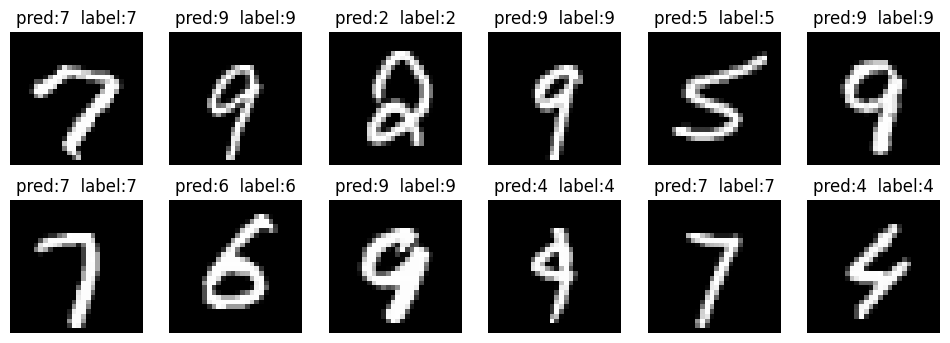

In [18]:

img,label = next(iter(val_data))
img,label = img.to(device),label.to(device)

with torch.no_grad():
  output = model(img)
  pred = output.argmax(dim = 1)

plt.figure(figsize=(12,4))
for idx in range(12):
  plt.subplot(2,6,idx+1)
  plt.imshow(img[idx].squeeze().cpu(),cmap='gray')
  plt.title(f'pred:{pred[idx].item()}  label:{label[idx].item()}')
  plt.axis('off')